This program analyzes the extent of bleaching in images of corals (*Pocillopora damicornis*) taken under experimental conditions. Sample data was used.

In [75]:
import cv2
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
def get_kmeans(data, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300)
    kmeans.fit(data)
    return kmeans

In [3]:
def get_clusters(kmeans):
    return kmeans.cluster_centers_

In [12]:
def display_cluster(img, kmeans, cluster):
    reshaped = np.copy(img.reshape(img.shape[0]*img.shape[1], img.shape[2]))
    predictions = kmeans.predict(reshaped)
    indicator = np.ones(reshaped.shape)
    indicator[np.where(predictions==cluster)] = 0 #select cluster
    reshaped[np.where(indicator)] = 0 #mask other pixels
    reshaped = reshaped.reshape(img.shape)
    plt.imshow(reshaped)

In [86]:
def compute_percentage(img, kmeans, bleached, healthy):
    height = img.shape[0]
    width = img.shape[1]
    channels = img.shape[2]
    data = img.reshape((height*width, channels))
    predictions = kmeans.predict(data)
    count = Counter(predictions).most_common()
    total = 0
    bleached_count = 0
    healthy_count = 0
    for cluster in bleached:
        num = 0
        for c in count:
            if c[0] == cluster:
                num = c[1]
        total += num
        bleached_count += num
    for cluster in healthy:
        num = 0
        for c in count:
            if c[0] == cluster:
                num = c[1]
        total += num
        healthy_count += num
    return bleached_count/total, healthy_count/total

In [109]:
def reject_outliers(x, data, m=2):
    return x[abs(data - np.mean(data)) < m * np.std(data)], data[abs(data - np.mean(data)) < m * np.std(data)]

Crop the pictures of the corals.

In [5]:
lenghts = [270, 220, 270, 320, 270, 240]
starts = [0, 313, 646, 926, 1304, 1620]

In [6]:
img_dir = '/Users/diegoeduardo/Desktop/image analysis/pictures/'
img_paths = glob(img_dir + '*JPG')

In [7]:
num_imgs = len(img_paths)
print(num_imgs)

1112


In [8]:
coral_pictures = []
for i in range(6):
    coral_pictures.append(np.empty((num_imgs, 260, lenghts[i], 3)))

In [9]:
for n, path in enumerate(img_paths):
    img = cv2.imread(path)
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    for i in range(6):
        start = starts[i]
        end = start + lenghts[i]
        coral = img[-320:-60,start:end]
        coral_pictures[i][n] = coral

Get centroids (in HSV color space) for bleached, healthy, and background pixels (some manual processing).

In [10]:
kmeans_list = []
for i in range(6):
    data = coral_pictures[i][:10:100]
    data = data.reshape((-1, 3))
    kmeans_list.append(get_kmeans(data))

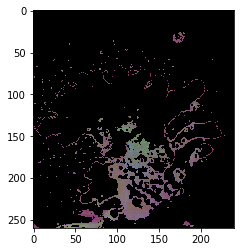

In [67]:
specimen = 5
cluster = 2
display_cluster(coral_pictures[specimen][0], kmeans_list[specimen], cluster)

In [68]:
#these were manually extracted
background = [[1,3], [0, 4], [0, 2], [0, 5], [0, 2], [0, 4]]
bleached = [[4,5], [1, 2, 3], [3, 4], [1, 2], [1, 3, 5], [1, 3]]
healthy = [[0,2], [5], [1, 5], [3, 4], [4], [2, 5]]

In [87]:
percentages = []
for i in range(6): #6 is number of specimens
    percentages.append([[], []])
    for j in range(num_imgs):
        img = coral_pictures[i][j]
        bleach_per, healthy_per = compute_percentage(img, kmeans_list[i], bleached[i], healthy[i])
        percentages[i][0].append(bleach_per)
        percentages[i][1].append(healthy_per)

Show the bleached area as function of time (in sample data, the corals did not experience any further bleaching).

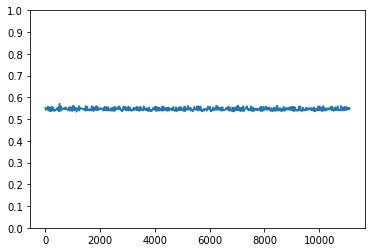

In [113]:
time = np.arange(0, num_imgs*10, 10)
percentage_bleached_mean = np.mean([percentages[0][0],percentages[1][0],percentages[2][0],
                                    percentages[3][0],percentages[4][0],percentages[5][0]], axis=0 )
time, percentage_bleached_mean = reject_outliers(time, percentage_bleached_mean)
percentage_healthy_mean = np.mean([percentages[0][1],percentages[1][1],percentages[2][1],
                                    percentages[3][1],percentages[4][1],percentages[5][1]], axis=0 )
plt.plot(time, percentage_bleached_mean)
#plt.plot(time, percentage_bleached_mean)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.legend(['% bleached'])
plt.show()

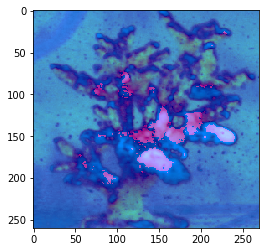

In [69]:
s = coral_pictures[0][0].astype(np.uint8)
img_HSV = cv2.cvtColor(s, cv2.COLOR_BGR2HSV)
plt.imshow(img_HSV)

Some previous testing.

In [70]:
kmeans_test = KMeans(n_clusters=6, init='k-means++', max_iter=300)

In [71]:
img_HSV_kmeans = np.reshape(img_HSV, (img_HSV.shape[0]*img_HSV.shape[1], 3))

In [72]:
kmeans_test.fit(img_HSV_kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [73]:
kmeans_test.cluster_centers_

array([[ 68.42771677, 142.11995456, 199.15107914],
       [ 45.76587036,  47.54379698, 155.06742576],
       [ 64.17293194, 101.62106796, 180.11152706],
       [171.74004051,  62.72991222, 169.87373396],
       [ 11.78551354,  86.11165049, 191.24080225],
       [175.92545555, 144.02153506, 243.08337935]])

In [77]:
predictions = kmeans_test.predict(img_HSV_kmeans)
Counter(predictions).most_common()

[(0, 26406), (2, 19229), (1, 13433), (4, 7840), (5, 1811), (3, 1481)]

In [ ]:
shape = (260*270, 3)
cluster = 2
img_HSV_kmeans_cluster0 = np.copy(img_HSV_kmeans)
indicator = np.ones(shape)
indicator[np.where(predictions==cluster)] = 0 #select cluster (first one in this case)
img_HSV_kmeans_cluster0[np.where(indicator)] = 0 #mask other pixels
img_HSV_kmeans_cluster0 = np.reshape(img_HSV_kmeans_cluster0, (260, 270, 3))
plt.imshow(img_HSV_kmeans_cluster0)

In [ ]:
bleached = [0, 2]
background = [1, 4]
healthy = [3, 5]

In [ ]:
new = coral_pictures[0][1000].astype(np.uint8)
new_HSV = cv2.cvtColor(new, cv2.COLOR_BGR2HSV)
plt.imshow(new_HSV)

In [ ]:
new_kmeans = np.reshape(new_HSV, (img_HSV.shape[0]*img_HSV.shape[1], 3))
predictions_new = kmeans_test.predict(new_kmeans)
shape = (260*270, 3)
cluster = 5
img_HSV_kmeans_cluster0 = np.copy(new_kmeans)
indicator = np.ones(shape)
indicator[np.where(predictions_new == cluster)] = 0 #select cluster
img_HSV_kmeans_cluster0[np.where(indicator)] = 0 #mask other pixels
img_HSV_kmeans_cluster0 = np.reshape(img_HSV_kmeans_cluster0, (260, 270, 3))
plt.imshow(img_HSV_kmeans_cluster0)

In [ ]:
data = coral_pictures[0][:100]
data.shape

In [ ]:
data = data.reshape((-1, 3))
data.shape

In [83]:
bleached[i]

[4, 5]